In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

%matplotlib inline

## Machine Learning Algorithms

We can breakdown the problem of Machine Learning into two subtypes:

### Regression

In general, these are problems where we are trying to predict a continuous variable. There are a few models that you 
can use to solve these type of problems:

- Ordinary Least Squares (Linear Regression)
- LASSO Regression
- Ridge Regression
- k nearest neighbours (kNN) Regression
- Elastic Net

You should already have seen and used the Linear Regression in practice. All subsequent models are similar in nature in the sense that we are trying to minimise the error function on the parameter space. I.e, find a set of $\pmb{\beta}$ such that $\epsilon(\pmb{\beta}) \geq 0$ is minimum. We saw that the error function for the **ordinary linear regression** is as follows: 

$$\epsilon(\pmb{\beta}) = MSE(\pmb{\beta})$$

For the LASSO, Ridge and Elastic Net regression models, we are trying to minimise the following functions with respect to $\pmb{\beta}$:

#### LASSO

$$\epsilon(\pmb{\beta}) = MSE(\pmb{\beta}) + \alpha\sum_{i=1}^{n}|\beta|_i$$ for some chosen $\alpha$.

#### Ridge

$$\epsilon(\pmb{\beta}) = MSE(\beta) + \alpha\pmb{\beta}^\intercal\pmb{\beta}$$ for some chosen $\alpha$. This is also equivalent to:
$$\epsilon(\pmb{\beta}) = MSE(\beta) + \alpha\sum_{i=1}^{n}\beta_{i}^2$$ 


### Classification

These are problems where we the target variable is **categorical**. The following models 
can be used to solve these type of problems:

- Logistic Regression
- kNN Classification
- Decision Trees

Note that the models listed so far are by no means exhaustive.

### Modelling on Iris

In [43]:
iris = sns.load_dataset("iris")

In [44]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [45]:
iris.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width',
       'species'],
      dtype='object')

Now, we implement **one hot encoding** in our feature matrix:

In [46]:
iris["is_setosa"] = (iris['species'] == "setosa")*1
iris["is_virginica"] = (iris['species'] == "virginica")*1
iris["is_versicolor"] = (iris['species'] == "versicolor")*1

In [47]:
iris.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species',
       'is_setosa', 'is_virginica', 'is_versicolor'],
      dtype='object')

We now split the data-set into our test and training sets containing 30% and 70% data respectively:

In [48]:
n = np.int(0.3*iris.shape[0])
idx = np.arange(0,iris.shape[0])
np.random.shuffle(idx)
iris_test = iris.iloc[idx[:n]]
iris_train = iris.iloc[idx[n:]]

Say we want to predict the sepal width of the plant based on the other features minus the species. Let's consider the ridge regression model:

We first need to standardise the feature observations as the $\alpha$ weights each parameter equally.

In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

Now, import the ridge regression model from the sklearn library:

In [50]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=1.5)

Let's get started with data preprocessing.

We first drop the target column from our feature set, as well as our species column, and convert the dataframe into a NumPy array.

In [51]:
x = iris_train.drop(['species','sepal_width'],axis = 1).values

In [52]:
scaler.fit(x)
x = scaler.transform(x)

In [53]:
y = iris_train['sepal_width']

ridge_model.fit(x,y)

Ridge(alpha=1.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

Now we fit the model using the predictors from the test set, be sure to scale your predictors first!

In [54]:
obs = iris_test['sepal_width']
predictor = iris_test.drop(['species','sepal_width'],axis=1).values
scaler.fit(predictor)
predictor = scaler.transform(predictor)

In [55]:
predicted = ridge_model.predict(predictor)

In [56]:
MSE = ((obs - predicted)**2).mean()
MSE

0.09038565954093915

Now, try testing the model on a different $\alpha$:

In [57]:
def train_ridge(alpha):
    ridge_model = Ridge(alpha)
    x = iris_train.drop(['species','sepal_width'],axis = 1).values
    scaler.fit(x)
    x = scaler.transform(x)
    y = iris_train['sepal_width']
    ridge_model.fit(x,y)
    obs = iris_test['sepal_width']
    predictor = iris_test.drop(['species','sepal_width'],axis=1).values
    scaler.fit(predictor)
    predictor = scaler.transform(predictor)
    predicted = ridge_model.predict(predictor)
    MSE = ((obs - predicted)**2).mean()
    return MSE


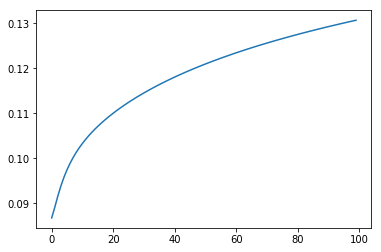

In [58]:
alpha_vec = pd.Series(np.arange(0.001,100,1))
mse_vec = alpha_vec.apply(train_ridge)
plt.plot(mse_vec)

Let's try training a LASSO model on the data:

In [59]:
from sklearn.linear_model import Lasso

In [60]:
def train_LASSO(alpha):
    ridge_model = Lasso(alpha)
    x = iris_train.drop(['species','sepal_width'],axis = 1).values
    scaler.fit(x)
    x = scaler.transform(x)
    y = iris_train['sepal_width']
    ridge_model.fit(x,y)
    obs = iris_test['sepal_width']
    predictor = iris_test.drop(['species','sepal_width'],axis=1).values
    scaler.fit(predictor)
    predictor = scaler.transform(predictor)
    predicted = ridge_model.predict(predictor)
    MSE = ((obs - predicted)**2).mean()
    return MSE


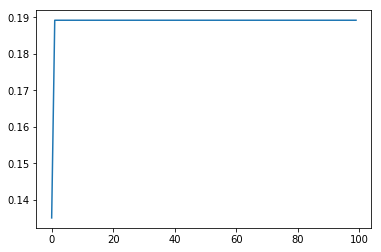

In [61]:
alpha_vec = pd.Series(np.arange(0.1,100,1))
mse_vec = alpha_vec.apply(train_LASSO)
plt.plot(mse_vec)

### Model Selection using Cross Validation

The idea of splitting the data into train and test sets extends to a routine where we can split the data up further so as to permutate what data the model can be used to train on. This is a heuristic method to allow us to be more confident of our model's prediction on general undiscovered data.

To do this, we split up the data set into k parts, where k is an integer. Then we train the model on k-1 parts of the data set and test on the remaining. We then iterate the training process with different sets of k-1 parts of the data and test on the remaining. We then calculate the average MSE from the process and call it the **k-fold cross validation error**. This can be used to determine model suitability.

In sklearn, we have a cross_validate object that will allow us to do cross validation easily. However, you need to be aware of the tendency of the cross_validation process to validate on a metric of its own choosing. This is why when we are comparing models from cross validation, we need to ensure that the scoring parameter is standard across all models.

In [62]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate(ridge_model,x,y,cv= 5,return_train_score=True,scoring='neg_mean_squared_error')


To find the average mean squared error from the cross validation process, we have:

In [63]:
cv_results['test_score'].mean()

-0.08057033148315294


In general, the higher the cross validated negative mean squared error, the better the model.

But what if we have many model parameters to consider? (recall the $\alpha$ parameter for the LASSO and Ridge models)

We can iterate through a list of $\alpha$ parameters and obtaining a CV error on each parameter:

In [64]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'alpha': [0.1,1,3,5,10,100,101]
    
}


clf = GridSearchCV(Ridge(),parameters,scoring="neg_mean_squared_error")

clf.fit(x,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.1, 1, 3, 5, 10, 100, 101]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

Then we can get the parameter with which the mean test score (the CV error) is minimal.

In [67]:
mean_test_score = clf.cv_results_['mean_test_score']
np.argmax(mean_test_score)

0

In [68]:
mean_test_score[1]

-0.07687840665701587

In [69]:
parameters['alpha'][1]

1

Thus we see that AMONGST the alpha parameters we tested on, $\alpha = 1$ gives the best CV error.

In fact, we can see how the parameters compare:

In [70]:
results = pd.DataFrame(clf.cv_results_)
results.head()

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.001081,0.000539,0.000219,0.000033,0.1,{'alpha': 0.1},-0.097619,-0.066233,-0.061804,-0.075219,0.015942,1,-0.056805,-0.069420,-0.073229,-0.066485,0.007019
1,0.000614,0.000018,0.000195,0.000020,1,{'alpha': 1},-0.102200,-0.067595,-0.060841,-0.076878,0.018116,2,-0.057733,-0.070807,-0.075454,-0.067998,0.007502
2,0.000698,0.000034,0.000203,0.000025,3,{'alpha': 3},-0.109258,-0.071547,-0.066866,-0.082557,0.018977,3,-0.060790,-0.074786,-0.080417,-0.071998,0.008252
3,0.000601,0.000001,0.000207,0.000038,5,{'alpha': 5},-0.114186,-0.074741,-0.072572,-0.087167,0.019126,4,-0.063563,-0.078055,-0.083929,-0.075182,0.008559
4,0.000789,0.000031,0.000206,0.000015,10,{'alpha': 10},-0.122868,-0.080856,-0.083714,-0.095812,0.019167,5,-0.069260,-0.084421,-0.090069,-0.081250,0.008786


## k-Nearest Neighbours

What if we use the kNN regressor to predict the sepal width now? We need to first import the classifier from scikit-learn:

In [103]:
from sklearn.neighbors import KNeighborsRegressor

In [107]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_neighbors': [1,2,3,4,5,10,50],
    'weights' : ['uniform','distance',lambda x: [1/(1+i) for i in x],lambda x: [1/(2+i) for i in x]]
    
}


kNNclf = GridSearchCV(KNeighborsRegressor(),parameters,scoring="neg_mean_squared_error")

kNNclf.fit(x,y)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 10, 50], 'weights': ['uniform', 'distance', <function <lambda> at 0x1154ff1e0>, <function <lambda> at 0x1154ff268>]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [108]:
results = pd.DataFrame(kNNclf.cv_results_)

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py

In [109]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.000639,0.000073,0.000733,0.000189,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",-0.142286,-0.125429,-0.140857,-0.136190,0.007632,23,-0.000571,-0.000000,-0.001857,-0.000810,0.000777
1,0.000387,0.000009,0.000478,0.000008,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",-0.142286,-0.125429,-0.140857,-0.136190,0.007632,22,-0.000571,-0.000000,-0.001857,-0.000810,0.000777
2,0.000556,0.000106,0.000644,0.000034,1,<function <lambda> at 0x1154ff1e0>,"{'n_neighbors': 1, 'weights': <function <lambd...",-0.142286,-0.125429,-0.140857,-0.136190,0.007632,23,-0.000571,-0.000000,-0.001857,-0.000810,0.000777
3,0.000443,0.000048,0.000628,0.000027,1,<function <lambda> at 0x1154ff268>,"{'n_neighbors': 1, 'weights': <function <lambd...",-0.142286,-0.125429,-0.140857,-0.136190,0.007632,23,-0.000571,-0.000000,-0.001857,-0.000810,0.000777
4,0.000380,0.000009,0.000426,0.000002,2,uniform,"{'n_neighbors': 2, 'weights': 'uniform'}",-0.155071,-0.080500,-0.106286,-0.113952,0.030923,20,-0.023000,-0.036500,-0.037107,-0.032202,0.006512
5,0.000379,0.000004,0.000473,0.000006,2,distance,"{'n_neighbors': 2, 'weights': 'distance'}",-0.144789,-0.085623,-0.108642,-0.113018,0.024352,17,-0.000286,-0.000000,-0.000929,-0.000405,0.000388
6,0.000429,0.000006,0.000611,0.000008,2,<function <lambda> at 0x1154ff1e0>,"{'n_neighbors': 2, 'weights': <function <lambd...",-0.153559,-0.081013,-0.105471,-0.113348,0.030136,18,-0.018812,-0.030375,-0.030177,-0.026455,0.005405
7,0.000575,0.000155,0.000790,0.000179,2,<function <lambda> at 0x1154ff268>,"{'n_neighbors': 2, 'weights': <function <lambd...",-0.154263,-0.080773,-0.105709,-0.113582,0.030514,19,-0.020677,-0.033186,-0.033314,-0.029059,0.005927
8,0.000590,0.000103,0.000650,0.000080,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",-0.141683,-0.086063,-0.096349,-0.108032,0.024162,15,-0.036190,-0.049000,-0.049683,-0.044958,0.006206
9,0.000471,0.000029,0.000542,0.000039,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",-0.134702,-0.090303,-0.101084,-0.108696,0.018908,16,-0.000286,-0.000000,-0.000929,-0.000405,0.000388
